data
https://www.kaggle.com/datasets/chetankv/dogs-cats-images/data

Import Libraries

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import cv2
import glob as gb
import pandas as pd
import seaborn as sns
import matplotlib.image as mpimg
from tqdm import tqdm
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from keras.optimizers import Adam

from keras.applications import DenseNet121
from keras.applications import ResNet50V2
from keras.applications import ResNet152V2
from keras.applications import InceptionV3
from keras.applications import Xception

Preprocessing

In [4]:
train_path = 'dog vs cat/dataset/training_set'
test_path = 'dog vs cat/dataset/test_set'

In [5]:
# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1.0/255,                # Rescale pixel values to [0, 1]
    rotation_range=20,              # Random rotation within 20 degrees
    width_shift_range=0.2,          # Random horizontal shift by 20% of image width
    height_shift_range=0.2,         # Random vertical shift by 20% of image height
    horizontal_flip=True,           # Random horizontal flipping
    fill_mode='nearest'             # Fill mode for new pixels after shifts/rotations
)

In [6]:
images_size = 200
batch_size = 32

In [7]:
train_generator = train_datagen.flow_from_directory(
    train_path,                     # Path to the training data
    target_size=(images_size, images_size),  # Resize images to this size
    batch_size=batch_size,           # Number of images in each batch
    seed=32,                         # Optional: Set a random seed for shuffling
    shuffle=True,                    # Shuffle the data during training
    class_mode='categorical'        # Mode for class labels (categorical for one-hot encoding)
)

Found 8000 images belonging to 2 classes.


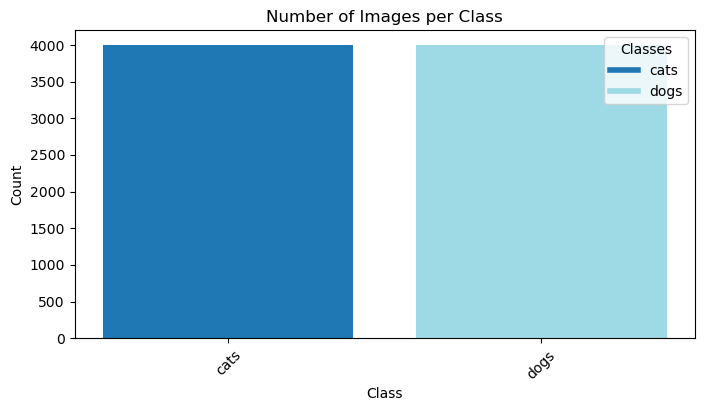

In [8]:
# Get the class labels
class_labels = list(train_generator.class_indices.keys())

# Calculate the count of images per class
class_counts = {label: 0 for label in class_labels}

for i in range(len(train_generator)):
    batch_data, batch_labels = train_generator[i]
    for j in range(len(batch_data)):
        class_idx = int(batch_labels[j].argmax())
        class_label = class_labels[class_idx]
        class_counts[class_label] += 1

# Define unique colors for each class
class_colors = plt.cm.tab20(np.linspace(0, 1, len(class_labels)))

# Create a bar chart with different colors for each class
plt.figure(figsize=(8, 4))
bars = plt.bar(class_counts.keys(), class_counts.values(), color=class_colors)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Number of Images per Class')
plt.xticks(rotation=45)

# Add a legend for class colors
legend_labels = [plt.Line2D([0], [0], color=class_colors[i], lw=4, label=class_labels[i]) for i in range(len(class_labels))]
plt.legend(handles=legend_labels, title="Classes")

plt.show()

In [9]:
# data augmentation for testing
test_datagen = ImageDataGenerator(rescale=1.0/255)  # Rescale pixel values to [0, 1]

In [10]:
# Create a generator for testing data
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(images_size, images_size),
    batch_size = batch_size,
    class_mode='categorical')

Found 2000 images belonging to 2 classes.


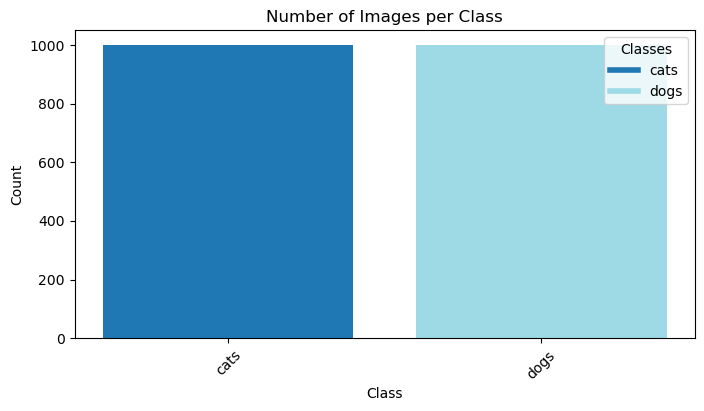

In [11]:
# Get the class labels
class_labels = list(test_generator.class_indices.keys())

# Calculate the count of images per class
class_counts = {label: 0 for label in class_labels}

for i in range(len(test_generator)):
    batch_data, batch_labels = test_generator[i]
    for j in range(len(batch_data)):
        class_idx = int(batch_labels[j].argmax())
        class_label = class_labels[class_idx]
        class_counts[class_label] += 1

# Define unique colors for each class
class_colors = plt.cm.tab20(np.linspace(0, 1, len(class_labels)))

# Create a bar chart with different colors for each class
plt.figure(figsize=(8, 4))
bars = plt.bar(class_counts.keys(), class_counts.values(), color=class_colors)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Number of Images per Class')
plt.xticks(rotation=45)

# Add a legend for class colors
legend_labels = [plt.Line2D([0], [0], color=class_colors[i], lw=4, label=class_labels[i]) for i in range(len(class_labels))]
plt.legend(handles=legend_labels, title="Classes")

plt.show()

In [12]:
def Show_Images(target_gen):
    # Get a batch of images and labels
    batch_images, batch_labels = next(target_gen)

    # Get class labels
    class_labels = list(target_gen.class_indices.keys())

    # Display images with labels
    plt.figure(figsize=(20, 20))
    for n , i in enumerate(list(np.random.randint(0,len(batch_images),16))):
        plt.subplot(4, 4, n + 1)
        plt.imshow(batch_images[i])
        plt.title(class_labels[np.argmax(batch_labels[i])])  # Display the class label
        plt.axis('off')
    plt.show()

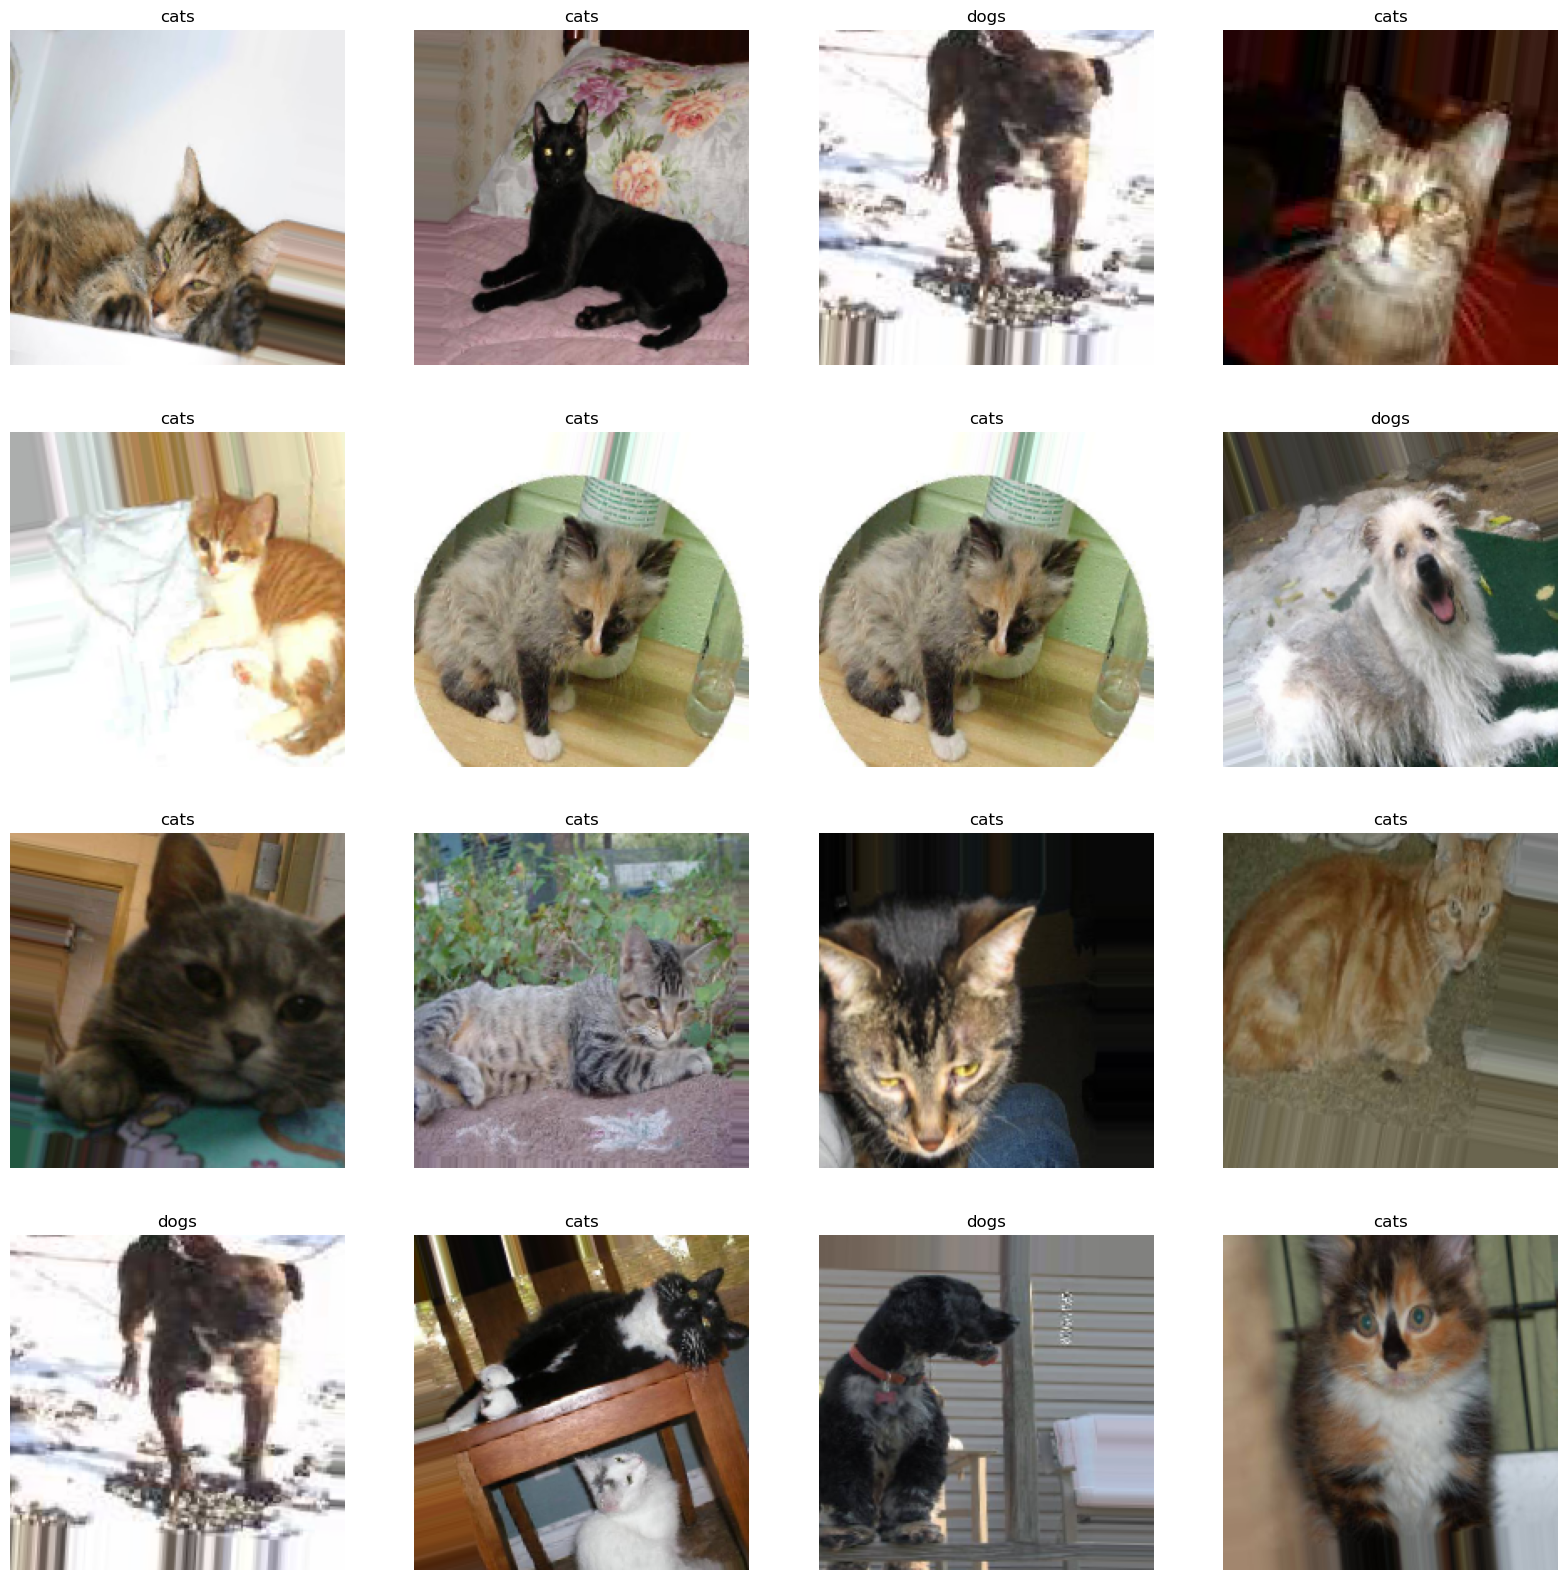

In [13]:
Show_Images(train_generator)

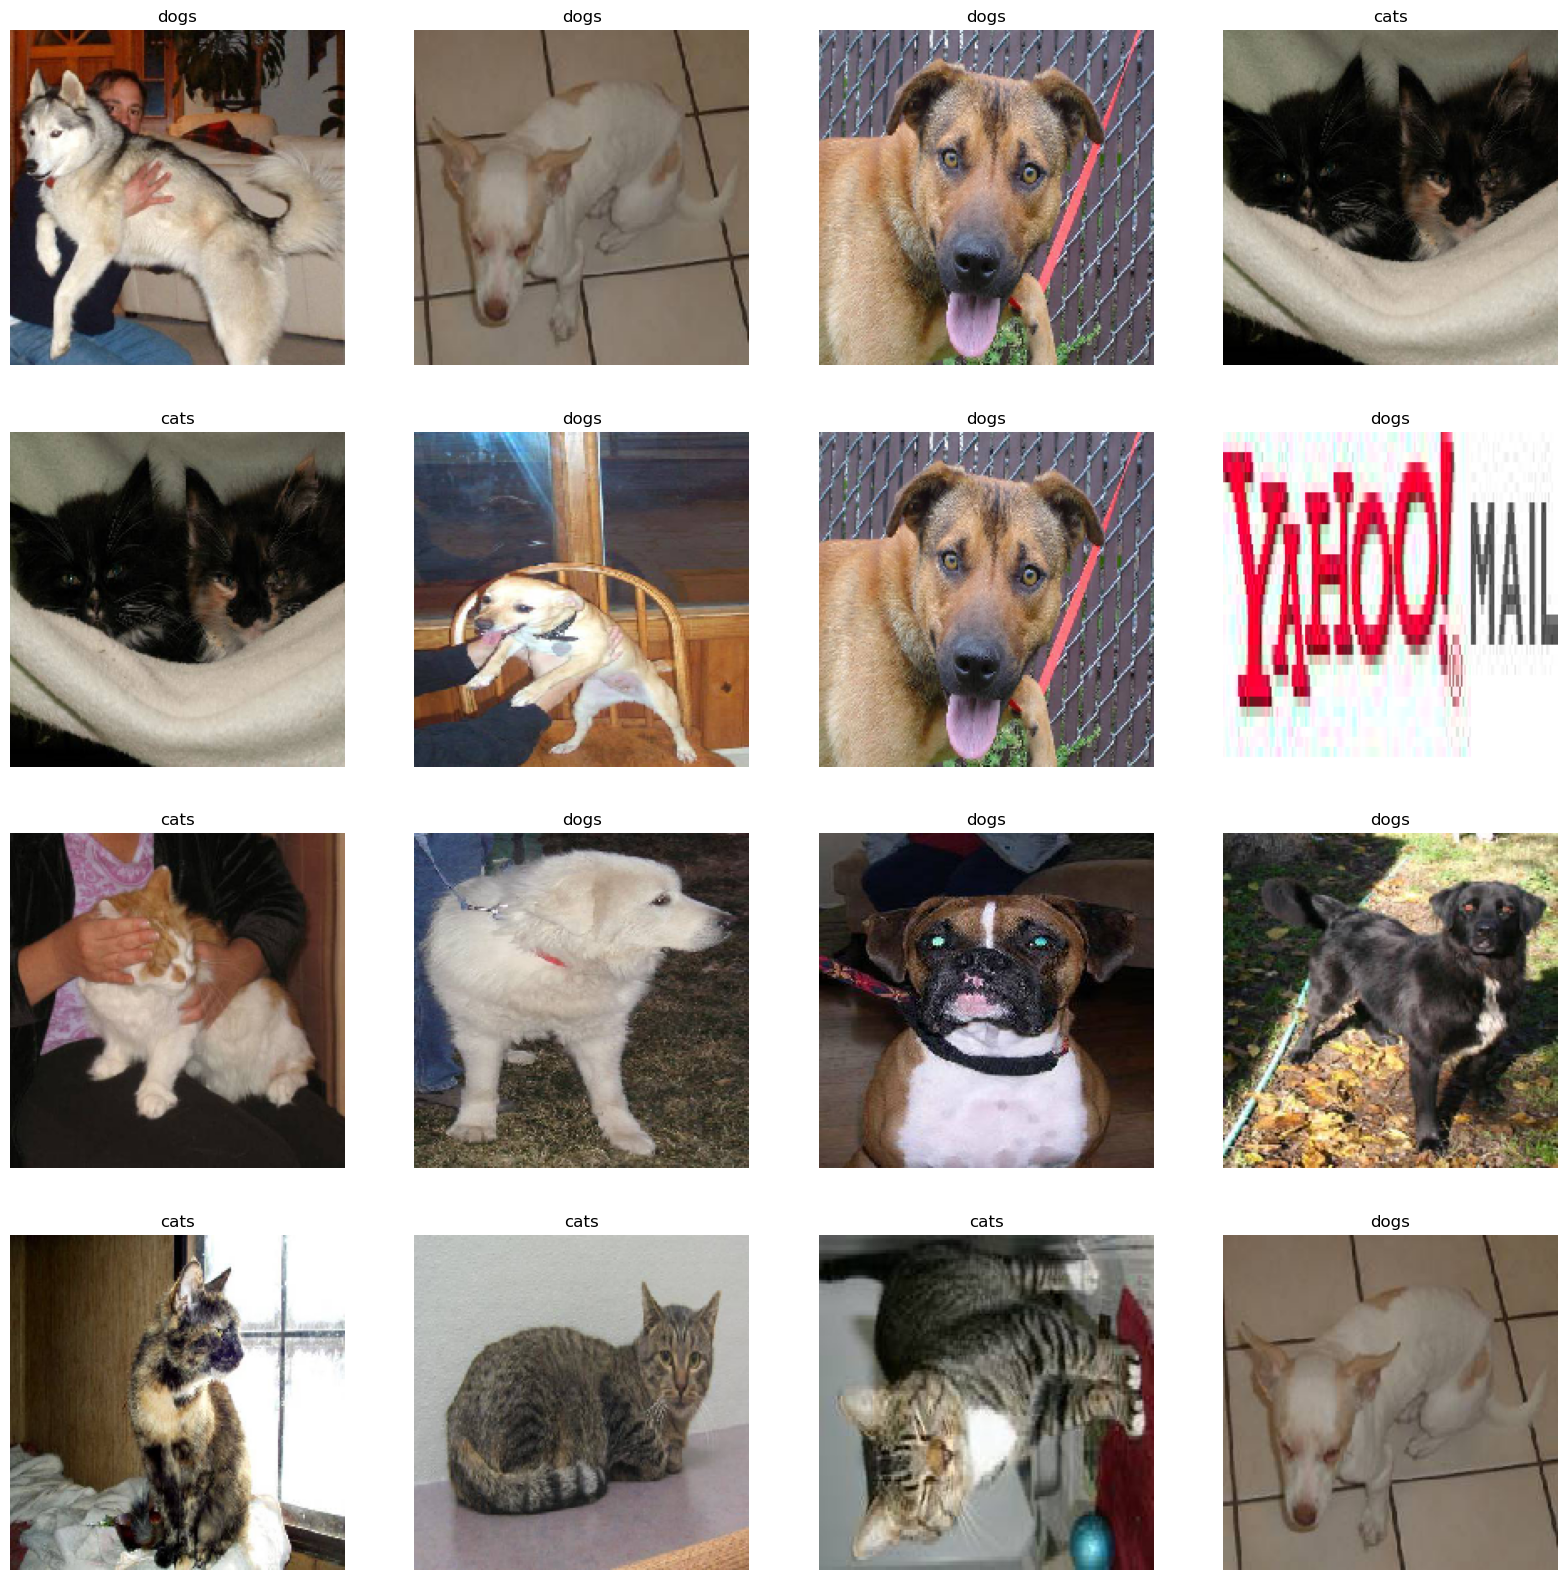

In [14]:
Show_Images(test_generator)

In [15]:
early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=5, # how many epochs to wait before stopping
    restore_best_weights=True,
)

In [16]:
# Configure the learning rate reduction callback
learning_rate_reduce = ReduceLROnPlateau(
    monitor='val_acc',   # Metric to monitor for changes (usually validation accuracy)
    patience=5,          # Number of epochs with no improvement after which learning rate will be reduced
    verbose=1,           # Verbosity mode (0: silent, 1: update messages)
    factor=0.5,          # Factor by which the learning rate will be reduced (e.g., 0.5 means halving)
    min_lr=0.00001       # Lower bound for the learning rate (it won't go below this value)
)

Exponential Decay

In [17]:
from tensorflow.keras import optimizers

# Create a learning rate schedule using Exponential Decay
learning_rate_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,  # Initial learning rate for training
    decay_steps=1000,            # Number of steps before decaying the learning rate
    decay_rate=0.5,              # Rate at which the learning rate decreases
)

# learning_rate = initial_learning_rate * decay_rate ^ (global_step / decay_steps)

In [18]:
from keras.callbacks import LearningRateScheduler

# Create a Learning Rate Scheduler callback using a pre-defined schedule
lr_callback = LearningRateScheduler(learning_rate_schedule)
callback=[ lr_callback , learning_rate_reduce ,early_stopping ]

Compare between TL Models

In [19]:
# Collect all TL models
TL_Models =[
    ResNet50V2(input_shape=(images_size, images_size, 3), weights='imagenet', include_top=False),
    ResNet152V2(input_shape=(images_size, images_size, 3), weights='imagenet', include_top=False),
    InceptionV3(input_shape=(images_size, images_size, 3), weights='imagenet', include_top=False),
    Xception(input_shape=(images_size, images_size, 3), weights='imagenet', include_top=False),
    DenseNet121( input_shape=(images_size, images_size, 3) ,weights='imagenet', include_top=False),
]

# Define all the TL models names. This will be later used during visualization
TL_Models_NAMES = [
    'ResNet50V2',
    'ResNet152V2',
    'InceptionV3',
    'Xception',
    'DenseNet121',
]

# Freeze the weights of all the TL models
for tl_model in TL_Models:
    tl_model.trainable = False

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 35s 0us/step
234545216/234545216 ━━━━━━━━━━━━━━━━━━━━ 74s 0us/step
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 30s 0us/step
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 24s 0us/step
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step


In [24]:
# Create variables to collect images and labels
subset_images = []
subset_labels = []

# Set the desired number of images you want in the subset
desired_count = 1000

# Loop through the generator until you have collected the desired number of images
for i in range(desired_count):
    # Generate a batch of data (images and labels)
    batch = next(train_generator)
    images, labels = batch
    subset_images.extend(images)
    subset_labels.extend(labels)

    # Check if you've collected enough images
    if len(subset_images) >= desired_count:
        break

# Convert the collected images and labels to numpy arrays
X_sub = np.array(subset_images)
y_sub = np.array(subset_labels)

In [26]:
# Initialize an empty list to hold the histories of each TL_models architecture.
HISTORIES = []

# Loop over every backbone in the BACKBONES list.
for tl_model in tqdm(TL_Models, desc="Training Tl Models"):
    
    # Create the simplest model architecture using the current backbone.
    model = keras.Sequential([
        tl_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.5),
        layers.Dense(2, activation='softmax')
    ])
    
    # Compile the model with the specified loss function, optimizer, and metrics.
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate = learning_rate_schedule),
        metrics=['accuracy']
    )
    
    # Train the model on a subset of the training data.
    history = model.fit(
        X_sub, y_sub,
        epochs=10,
        validation_split=0.2,
        batch_size=batch_size
    )
        
    # Store the history of the trained model.
    HISTORIES.append(history.history)

Training Tl Models:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 26s 835ms/step - accuracy: 0.7958 - loss: 0.9509 - val_accuracy: 0.9366 - val_loss: 0.1872
Epoch 2/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 755ms/step - accuracy: 0.9442 - loss: 0.2311 - val_accuracy: 0.9805 - val_loss: 0.1100
Epoch 3/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 775ms/step - accuracy: 0.9816 - loss: 0.0851 - val_accuracy: 0.9707 - val_loss: 0.1418
Epoch 4/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 768ms/step - accuracy: 0.9688 - loss: 0.1211 - val_accuracy: 0.9561 - val_loss: 0.1448
Epoch 5/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 790ms/step - accuracy: 0.9818 - loss: 0.0611 - val_accuracy: 0.9805 - val_loss: 0.0924
Epoch 6/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 764ms/step - accuracy: 0.9825 - loss: 0.0616 - val_accuracy: 0.9756 - val_loss: 0.1281
Epoch 7/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 768ms/step - accuracy: 0.9898 - loss: 0.0504 - val_accuracy: 0.9805 - val_loss: 0.1226
Epoch 8/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 778ms/step - accuracy: 0.9817 - loss: 0.0707 - val_accu

Training Tl Models:  20%|██        | 1/5 [03:27<13:48, 207.03s/it]

Epoch 1/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.8202 - loss: 0.9061 - val_accuracy: 0.9415 - val_loss: 0.2910
Epoch 2/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.9598 - loss: 0.2545 - val_accuracy: 0.9756 - val_loss: 0.0854
Epoch 3/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.9644 - loss: 0.1772 - val_accuracy: 0.9756 - val_loss: 0.0769
Epoch 4/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.9808 - loss: 0.1132 - val_accuracy: 0.9756 - val_loss: 0.1245
Epoch 5/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.9851 - loss: 0.0704 - val_accuracy: 0.9756 - val_loss: 0.1101
Epoch 6/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.9742 - loss: 0.0879 - val_accuracy: 0.9756 - val_loss: 0.1347
Epoch 7/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.9909 - loss: 0.0305 - val_accuracy: 0.9756 - val_loss: 0.1157
Epoch 8/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.9900 - loss: 0.0423 - val_accuracy: 0.9805 - val_loss:

Training Tl Models:  40%|████      | 2/5 [13:13<21:30, 430.22s/it]

Epoch 1/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 566ms/step - accuracy: 0.7034 - loss: 2.7318 - val_accuracy: 0.9561 - val_loss: 0.3509
Epoch 2/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 11s 432ms/step - accuracy: 0.9522 - loss: 0.2377 - val_accuracy: 0.9561 - val_loss: 0.3603
Epoch 3/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 11s 435ms/step - accuracy: 0.9849 - loss: 0.0661 - val_accuracy: 0.9512 - val_loss: 0.3565
Epoch 4/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 11s 422ms/step - accuracy: 0.9896 - loss: 0.0358 - val_accuracy: 0.9610 - val_loss: 0.2976
Epoch 5/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 11s 444ms/step - accuracy: 0.9899 - loss: 0.0414 - val_accuracy: 0.9610 - val_loss: 0.3131
Epoch 6/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 12s 447ms/step - accuracy: 0.9769 - loss: 0.0869 - val_accuracy: 0.9561 - val_loss: 0.3683
Epoch 7/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 11s 441ms/step - accuracy: 0.9930 - loss: 0.0275 - val_accuracy: 0.9512 - val_loss: 0.4212
Epoch 8/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 12s 445ms/step - accuracy: 0.9902 - loss: 0.0553 - val_accu

Training Tl Models:  60%|██████    | 3/5 [15:16<09:40, 290.16s/it]

Epoch 1/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.8846 - loss: 0.2462 - val_accuracy: 0.9659 - val_loss: 0.0867
Epoch 2/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.9846 - loss: 0.0406 - val_accuracy: 0.9707 - val_loss: 0.1040
Epoch 3/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.9890 - loss: 0.0448 - val_accuracy: 0.9561 - val_loss: 0.1346
Epoch 4/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.9890 - loss: 0.0204 - val_accuracy: 0.9707 - val_loss: 0.0864
Epoch 5/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.9934 - loss: 0.0208 - val_accuracy: 0.9756 - val_loss: 0.0784
Epoch 6/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.9941 - loss: 0.0172 - val_accuracy: 0.9854 - val_loss: 0.0501
Epoch 7/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.9848 - loss: 0.0390 - val_accuracy: 0.9756 - val_loss: 0.0750
Epoch 8/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.9976 - loss: 0.0122 - val_accuracy: 0.9659 - val_loss:

Training Tl Models:  80%|████████  | 4/5 [20:22<04:56, 296.33s/it]

Epoch 1/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.8090 - loss: 0.5081 - val_accuracy: 0.9415 - val_loss: 0.1818
Epoch 2/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.9318 - loss: 0.2119 - val_accuracy: 0.9707 - val_loss: 0.0891
Epoch 3/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.9391 - loss: 0.2347 - val_accuracy: 0.9512 - val_loss: 0.1540
Epoch 4/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.9434 - loss: 0.2320 - val_accuracy: 0.9707 - val_loss: 0.0690
Epoch 5/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.9644 - loss: 0.1149 - val_accuracy: 0.9366 - val_loss: 0.2437
Epoch 6/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.9648 - loss: 0.1770 - val_accuracy: 0.9707 - val_loss: 0.0818
Epoch 7/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.9463 - loss: 0.2650 - val_accuracy: 0.9707 - val_loss: 0.0753
Epoch 8/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.9581 - loss: 0.0851 - val_accuracy: 0.9756 - val_loss:

Training Tl Models: 100%|██████████| 5/5 [25:22<00:00, 304.47s/it]


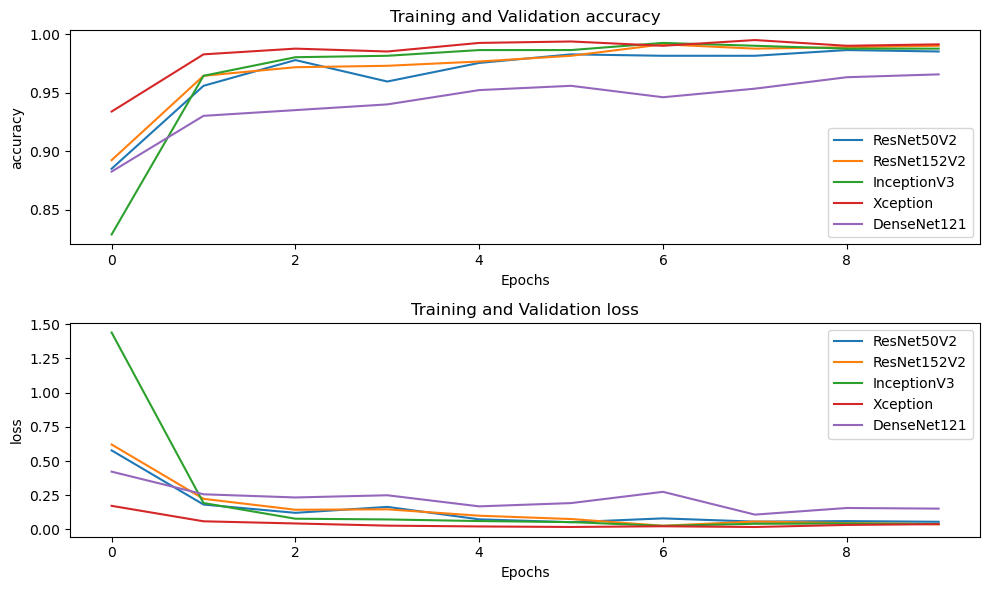

In [27]:
import matplotlib.pyplot as plt

# Define the metrics to plot (e.g., 'accuracy' and 'loss')
metrics_to_plot = ['accuracy', 'loss']

# Create subplots for each metric
fig, axes = plt.subplots(len(metrics_to_plot), 1, figsize=(10, 6))

for i, metric in enumerate(metrics_to_plot):
    plt.subplot(2, 1, i+1)  # Create subplots for each metric
    for idx, history in enumerate(HISTORIES):
        plt.plot(history[metric], label=TL_Models_NAMES[idx])
    plt.title(f'Training and Validation {metric}')
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()

plt.tight_layout()
plt.show()

Transfer Learning

In [28]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=(images_size, images_size, 3))

In [29]:
# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

Build the model

In [30]:
model = tf.keras.models.Sequential([
    base_model,
    
    layers.Flatten(),
    
    layers.Dense(256,activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2,activation='softmax'),
])

model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 7, 7, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,552,362 (177.58 MB)

 Trainable params: 25,690,882 (98.00 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [31]:
optimizer = optimizers.Adam(learning_rate=learning_rate_schedule)

In [32]:
model.compile(optimizer=optimizer,
             loss="categorical_crossentropy",
              metrics=['accuracy']
             )

In [35]:
# Define a new learning rate schedule function
def new_learning_rate_schedule(epoch, lr):
    # For example, a learning rate that decays by a factor of 0.1 every 5 epochs
    if epoch % 5 == 0 and epoch > 0:
        lr = lr * 0.1
    return float(lr)  # Ensure the output is a standard Python float

# Create a Learning Rate Scheduler callback using the new learning rate schedule
lr_callback = LearningRateScheduler(new_learning_rate_schedule)

# Define other callbacks like learning rate reduction and early stopping
learning_rate_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Combine all callbacks into a list
callback = [lr_callback, learning_rate_reduce, early_stopping]

In [37]:
# Define an optimizer with a fixed learning rate
optimizer = Adam(learning_rate=0.001)  # You can change the initial learning rate here

# Compile your model with the optimizer
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


In [39]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=5,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    callbacks=callback
)

Epoch 1/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 343s 1s/step - accuracy: 0.9705 - loss: 0.0837 - val_accuracy: 0.9874 - val_loss: 0.0479 - learning_rate: 0.0010
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 358s 1s/step - accuracy: 0.9760 - loss: 0.0780 - val_accuracy: 0.9869 - val_loss: 0.0466 - learning_rate: 0.0010
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 357s 1s/step - accuracy: 0.9776 - loss: 0.0609 - val_accuracy: 0.9869 - val_loss: 0.0494 - learning_rate: 0.0010
Epoch 4/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 359s 1s/step - accuracy: 0.9773 - loss: 0.0716 - val_accuracy: 0.9844 - val_loss: 0.0580 - learning_rate: 0.0010
Epoch 5/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 357s 1s/step - accuracy: 0.9765 - loss: 0.0672 - val_accuracy: 0.9829 - val_loss: 0.0547 - learning_rate: 0.0010


MLP

In [40]:
# اضافه کردن مدل MLP به مدل‌ها
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout

# Flatten تصاویر (برای MLP)
X_flat = X_sub.reshape(X_sub.shape[0], -1)

# تعریف مدل MLP
mlp_model = Sequential([
    Dense(512, activation='relu', input_shape=(X_flat.shape[1],)),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

# کامپایل مدل
mlp_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# آموزش مدل
mlp_history = mlp_model.fit(
    X_flat, y_sub,
    epochs=10,
    batch_size=32,
    validation_split=0.2
)

# اضافه کردن به لیست HISTORIES برای رسم نمودار
HISTORIES.append(mlp_history.history)
TL_Models_NAMES.append('MLP')


c:\Users\pouya\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 11s 400ms/step - accuracy: 0.4748 - loss: 53.6952 - val_accuracy: 0.5268 - val_loss: 10.6921
Epoch 2/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 391ms/step - accuracy: 0.5164 - loss: 25.5727 - val_accuracy: 0.5220 - val_loss: 0.9473
Epoch 3/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 391ms/step - accuracy: 0.5136 - loss: 10.7445 - val_accuracy: 0.4927 - val_loss: 1.0342
Epoch 4/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 386ms/step - accuracy: 0.4793 - loss: 7.5160 - val_accuracy: 0.5171 - val_loss: 0.8348
Epoch 5/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 391ms/step - accuracy: 0.5237 - loss: 3.7813 - val_accuracy: 0.5171 - val_loss: 0.8304
Epoch 6/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 390ms/step - accuracy: 0.5100 - loss: 2.0500 - val_accuracy: 0.5220 - val_loss: 0.6920
Epoch 7/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 399ms/step - accuracy: 0.5416 - loss: 0.7087 - val_accuracy: 0.5122 - val_loss: 0.6942
Epoch 8/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 398ms/step - accuracy: 0.5366 - loss: 0.6946 - val_

Evaluate the model

In [41]:
# Evaluate on test dataset
score = model.evaluate(test_generator, verbose=False)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.04669501632452011
Test accuracy: 0.9865000247955322


In [42]:
# Accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

<Figure size 640x480 with 0 Axes>

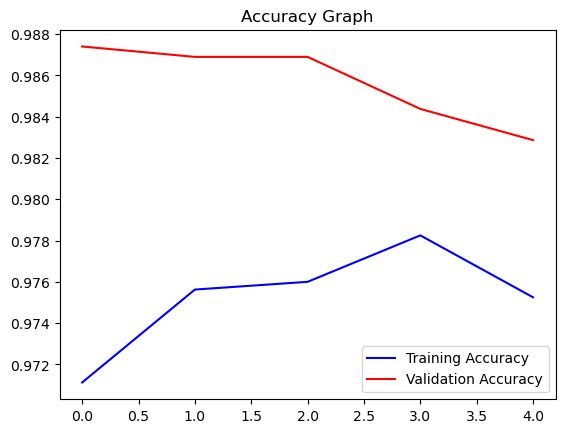

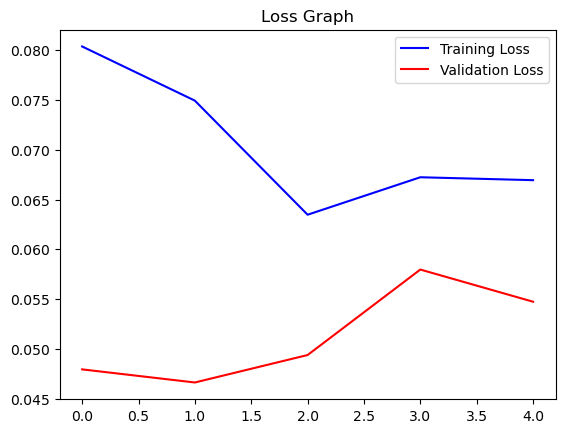

In [43]:
# Loss
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

63/63 ━━━━━━━━━━━━━━━━━━━━ 61s 946ms/step


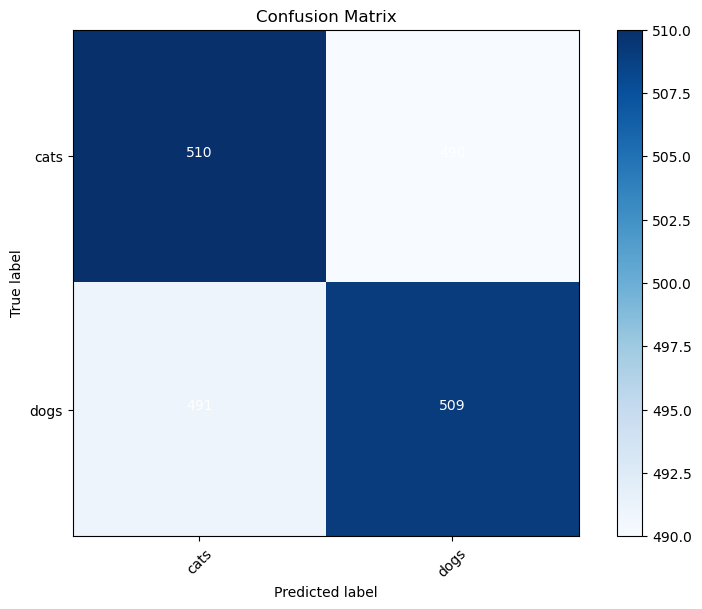

In [44]:
# Confusion Matrix
import itertools

# Make predictions on the test data
predictions = model.predict(test_generator)

# Convert probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Get true labels from the test_generator
true_labels = test_generator.classes

# Calculate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Define class names (assuming you have class_names defined)
class_names = test_generator.class_indices.keys()

# Plot confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title="Confusion Matrix", cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

# Plot non-normalized confusion matrix
plt.figure(figsize=(8, 6))
plot_confusion_matrix(cm, classes=class_names, title="Confusion Matrix")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 988ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 988ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 998ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 992ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 979ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 964ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 974ms/step


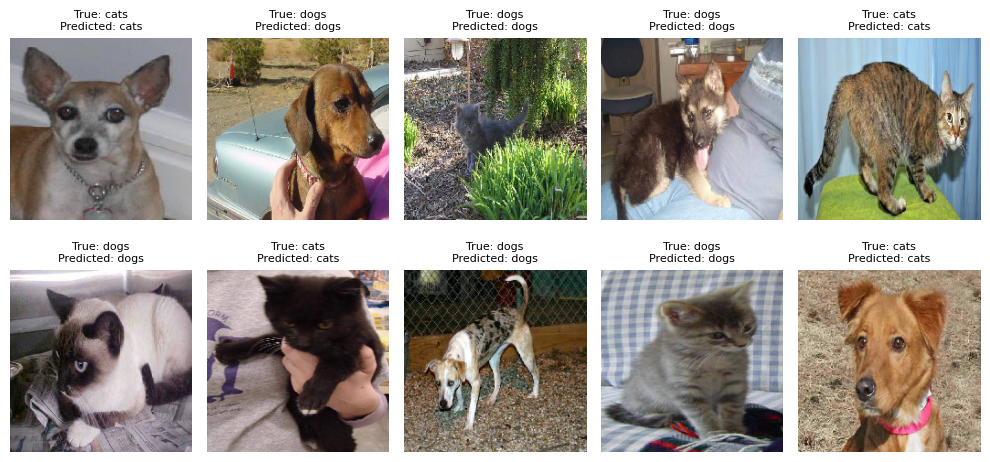

In [45]:
# Collect true labels and model predictions
true_labels = []
predicted_labels = []
class_names = test_generator.class_indices.keys()    
class_names = list(class_names)
num_batches = len(test_generator)
for i in range(10):
    x_batch, y_batch = test_generator[i]
    predictions = model.predict(x_batch)
    true_labels.extend(np.argmax(y_batch, axis=1))  # Convert one-hot encoded labels to class indices
    predicted_labels.extend(np.argmax(predictions, axis=1))


true_class_labels = [class_names[i] for i in true_labels]
predicted_class_labels = [class_names[i] for i in predicted_labels]

# Plot true labels and predicted labels
plt.figure(figsize=(10, 5))
num_samples_to_display = min(10, len(x_batch))  # Display up to 10 samples or less if available
for i in range(num_samples_to_display):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_batch[i])
    plt.title(f'True: {true_class_labels[i]}\nPredicted: {predicted_class_labels[i]}', fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()

MLP

Test loss: 0.035007230937480927
Test accuracy: 1.0


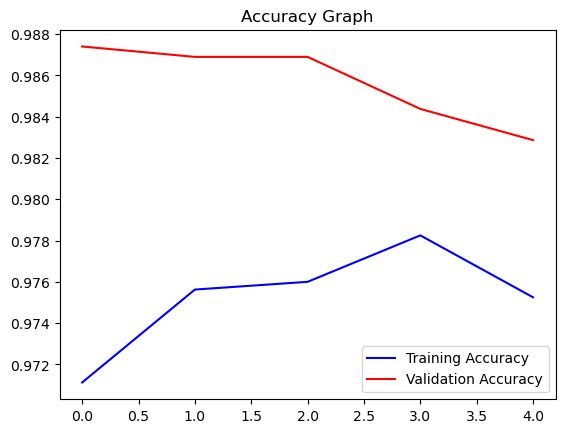

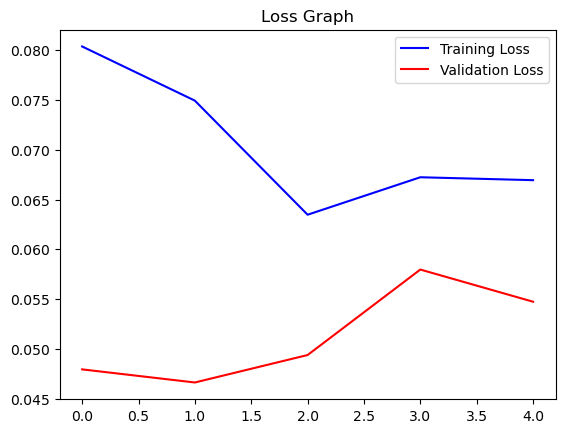

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 913ms/step


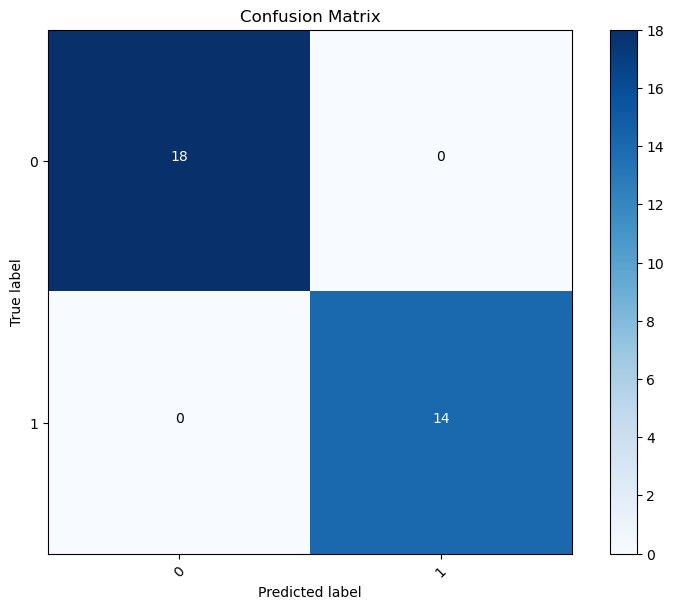

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

# ====== Evaluate the model ======
score = model.evaluate(x_batch, y_batch, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# ====== Accuracy Graph ======
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

# ====== Loss Graph ======
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

# ====== Confusion Matrix ======
# Make predictions on the test data
predictions = model.predict(x_batch)

# Convert probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Get true labels
true_labels = np.argmax(y_batch, axis=1)

# Calculate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Define class names (you may have them from your dataset)
class_names = [str(i) for i in range(y_batch.shape[1])]  # or provide your own list if available

# Plot confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title="Confusion Matrix", cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

plt.figure(figsize=(8, 6))
plot_confusion_matrix(cm, classes=class_names, title="Confusion Matrix")
plt.show()